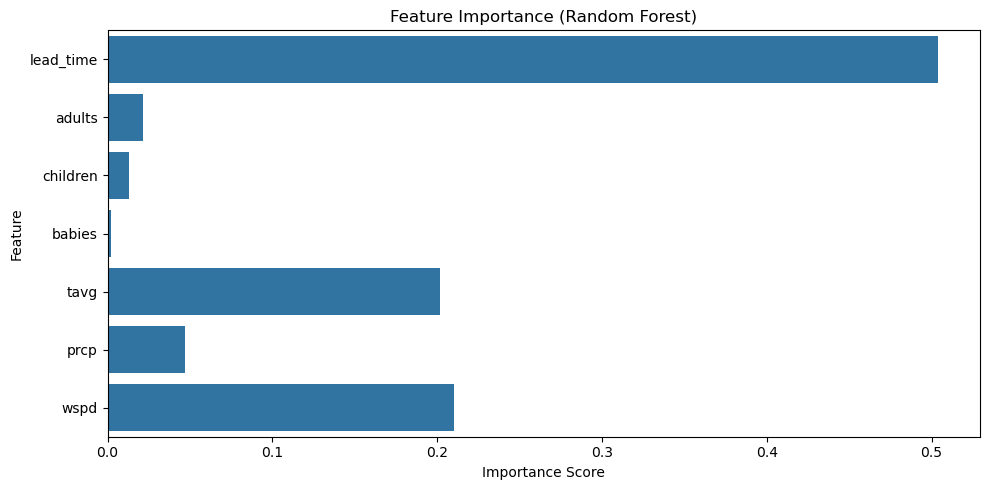

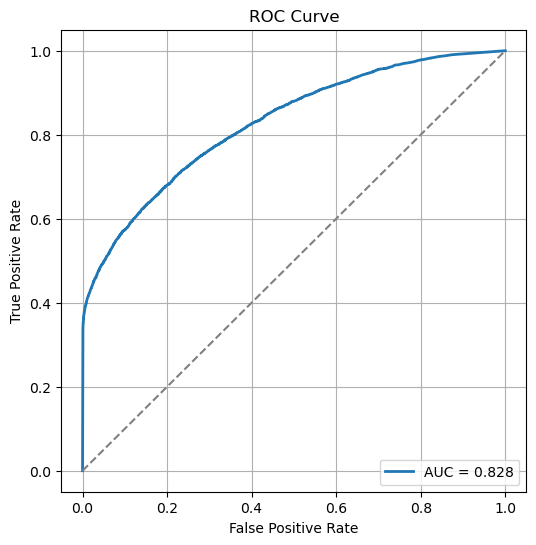

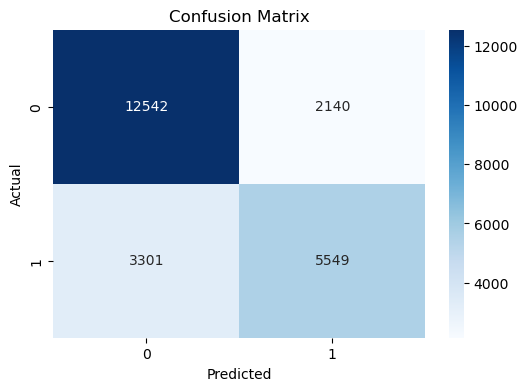

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     14682
           1       0.72      0.63      0.67      8850

    accuracy                           0.77     23532
   macro avg       0.76      0.74      0.75     23532
weighted avg       0.77      0.77      0.77     23532



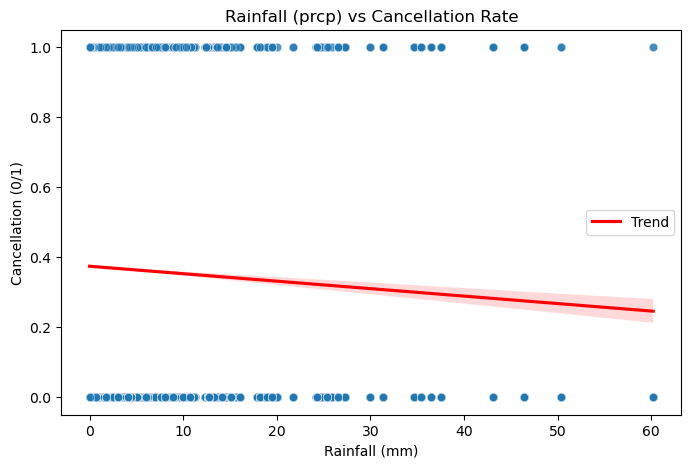

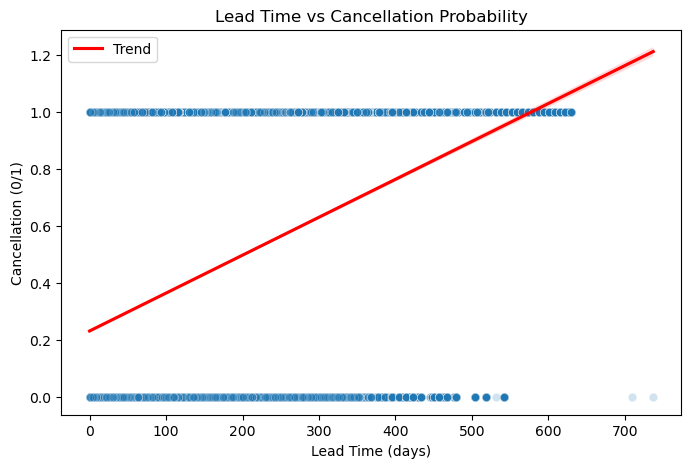

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

hb = pd.read_csv("C:/Users/12564/Desktop/hotel_bookings.csv")
alg = pd.read_csv('C:/Users/12564/Desktop/algarve_with_weather.csv')
lis = pd.read_csv('C:/Users/12564/Desktop/lisbon_with_weather.csv')

# -----------------------------
# 2. deal date format
# -----------------------------
hb['arrival_date'] = pd.to_datetime(
    hb['arrival_date_month'] + ' ' +
    hb['arrival_date_day_of_month'].astype(str) + ' ' +
    hb['arrival_date_year'].astype(str)
)

alg['obs_date'] = pd.to_datetime(alg['obs_date'])
lis['obs_date'] = pd.to_datetime(lis['obs_date'])

# -----------------------------
# 3. match weather by hotel type
# Resort → Algarve
# City → Lisbon
# -----------------------------
hb_resort = hb[hb['hotel'] == 'Resort Hotel'].merge(
    alg, left_on='arrival_date', right_on='obs_date', how='left')

hb_city = hb[hb['hotel'] == 'City Hotel'].merge(
    lis, left_on='arrival_date', right_on='obs_date', how='left')

df = pd.concat([hb_resort, hb_city], ignore_index=True)

# -----------------------------
# 4.create model features
# -----------------------------
features = ['lead_time', 'adults', 'children', 'babies',
            'tavg', 'prcp', 'wspd']

df['children'] = df['children'].fillna(0)  # 避免缺失导致训练失败

df_clean = df.dropna(subset=features + ['is_canceled'])

X = df_clean[features]
y = df_clean['is_canceled']

# -----------------------------
# 5. spilt data in train and test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 6. train model
# -----------------------------
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
model.fit(X_train, y_train)

# ---7. Feature Importance  ---
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ---8. aic and roc curve  ---
y_prob = model.predict_proba(X_test)[:, 1]  # 取取消概率
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#---9.confusion_matrix---
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -----------------------------
# 10. prodict and analysis
# -----------------------------

report = classification_report(y_test, pred)
print(report)

df_weather_cancel = df_clean.copy()
df_weather_cancel['cancel_rate'] = df_weather_cancel['is_canceled']

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_weather_cancel, x="prcp", y="cancel_rate", alpha=0.3)
sns.regplot(data=df_weather_cancel, x="prcp", y="cancel_rate",
            scatter=False, color="red", label="Trend")
plt.title("Rainfall (prcp) vs Cancellation Rate")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Cancellation (0/1)")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_clean, x="lead_time", y="is_canceled", alpha=0.2)
sns.regplot(data=df_clean, x="lead_time", y="is_canceled",
            scatter=False, color="red", label="Trend")

plt.title("Lead Time vs Cancellation Probability")
plt.xlabel("Lead Time (days)")
plt.ylabel("Cancellation (0/1)")
plt.legend()
plt.show()
